# Notebook to Visualize Huc10 Results - Prototype Model w/ New Data

# Step 0 - Set up Notebook

In [1]:
# import needed libaries
import os
import boto3
import mlflow
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from snowML.datapipe import snow_types as st # make sure you have installed snowML package 

In [2]:
# initialize erathengine credentials
import ee
ee.Authenticate()

True

# Step1 - Download MLFlow Metrics

In [3]:
# function to retrieve metrics from ML server 
def load_ml_metrics(tracking_uri, run_id, save_local=False):
    mlflow.set_tracking_uri(tracking_uri)
    client = mlflow.MlflowClient()
    # Get all metric keys from the run
    run_data = client.get_run(run_id).data
    metric_keys = run_data.metrics.keys()
    # Retrieve full metric history for each key
    all_metrics = []
    for metric in metric_keys:
        history = client.get_metric_history(run_id, metric)
        for record in history:
            all_metrics.append({
                "Metric": metric,
                "Step": record.step,
                "Value": record.value
            })
    
    # Convert to DataFrame
    metrics_df = pd.DataFrame(all_metrics)
    
    # Save to CSV if needed
    if save_local:
        f_out = f"run_id_data/metrics_from_{run_id}.csv"
        metrics_df.to_csv(f_out, index=False)

    return metrics_df

In [4]:
# function to extract only a specific metric
def extract_metric(df, metric_name):
    """Extracts rows where the Metric column ends with 'metric_name' and returns only Metric and Value columns."""
    return df[df['Metric'].str.endswith(metric_name)][['Metric', 'Value']].sort_values(by='Metric')

**Approach A** Retrieve metrics frol MLFlow Tracking server

**Important Note** The cell below for is use when running the notebook from within a Sagemaker Studio instance, with access to the Frosty Dawgs MLFlow Tracking Server for purposes of retrieving model metrics.  If that is not the case, you may instead retrieve the data from the local file names as demonstrated under step 1B.  

**Approach B** 
Load metrics localy from saved files. 

In [5]:

df_orig30 = pd.read_csv("metric_runs/Original30.csv")
#df_orig200 = pd.read_csv("metric_runs/Original200.csv")  
df_orig10 = pd.read_csv("metric_runs/Original10.csv")  
#df_new10 = pd.read_csv("metric_runs/New10.csv") 
df_new200 = pd.read_csv("metric_runs/New200.csv")  
df_new10_rerun = pd.read_csv("../../data/run_id_data/metrics_from_bfdd8164ce1f46d8a9418be41a70ffdf.csv")
df_orig200_rerun = pd.read_csv("../../data/run_id_data/metrics_from_02a508daab8e42b2a5f1baab194cd744.csv")

In [6]:

# Now extract separate dataframes witht the test_kge and test_mse metrics, respectively 
df_orig200_tkge = extract_metric(df_orig200_rerun, "test_kge")
df_orig200_tmse = extract_metric(df_orig200_rerun, "test_mse")

 
df_orig30_tkge = extract_metric(df_orig30, "test_kge")
df_orig30_tmse = extract_metric(df_orig30, "test_mse")


df_orig10_tkge = extract_metric(df_orig10, "test_kge")
df_orig10_tmse = extract_metric(df_orig10, "test_mse")

 
df_new10_tkge = extract_metric(df_new10_rerun, "test_kge")
df_new10_tmse = extract_metric(df_new10_rerun, "test_mse")


df_new200_tkge = extract_metric(df_new200, "test_kge")
df_new200_tmse = extract_metric(df_new200, "test_mse")


In [7]:
# Display an example
df_orig200_tkge

,Metric,Value
27,1711000504_test_kge,0.507048
2,1711000505_test_kge,0.651840
17,1711000506_test_kge,0.510110
8,1711000507_test_kge,0.635140
5,1711000508_test_kge,0.575051
26,1711000509_test_kge,0.612250
24,1711000511_test_kge,0.569751


# Step 2 - Define Plotting Function

In [8]:
# define a function to plot results side by side 

def plot_side_by_side(*dfs_labels, title = "Side-by-Side Metric Comparison", save_local = False):
    """Plots a side-by-side bar chart comparing values from multiple DataFrames by Metric.
    
    Parameters:
        *dfs_labels: Variable-length arguments where each pair is (df, label).
                     Example usage: plot_side_by_side(df1, "Label1", df2, "Label2", df3, "Label3")
    """
    
    if len(dfs_labels) % 2 != 0:
        raise ValueError("Arguments must be given as (df1, label1, df2, label2, ...).")
    
    # Process input pairs
    dfs = dfs_labels[0::2]
    labels = dfs_labels[1::2]

    # Merge all DataFrames on 'Metric'
    merged_df = dfs[0][['Metric', 'Value']].rename(columns={'Value': f'Value_{labels[0]}'})
    for df, label in zip(dfs[1:], labels[1:]):
        merged_df = merged_df.merge(df[['Metric', 'Value']], on='Metric', how='inner', suffixes=('', f'_{label}'))
        merged_df = merged_df.rename(columns={'Value': f'Value_{label}'})  # Rename to avoid conflicts

    metrics = merged_df['Metric']
    values = [merged_df[f'Value_{label}'] for label in labels]
    medians = [np.median(val) for val in values]
    
    x = np.arange(len(metrics))  # Label locations
    width = 0.8 / len(labels)  # Adjust bar width dynamically based on the number of datasets
    
    fig, ax = plt.subplots(figsize=(12, 6))

    # Create bars for each dataset
    for i, (val, label, median) in enumerate(zip(values, labels, medians)):
        bars = ax.bar(x + (i - len(labels)/2) * width, val, width, label=label, alpha=0.7)
        color = bars[0].get_facecolor()  # Get the color of the bars
        # Draw a median line for each dataset
        ax.axhline(y=median, color=bars[0].get_facecolor(), linestyle='dashed', linewidth=2, alpha=0.8)
        ax.text(len(metrics) + 0.1, median, f"{label} Median: {median:.3f}", 
                va='center', ha='left', color=color, fontsize=10, fontweight='bold')
       
    ax.set_xlabel("Metric")
    ax.set_ylabel("Value")
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(metrics, rotation=45, ha="right")
    ax.legend()

    plt.show()
    if save_local: 
        title_r = title.replace(" ", "_")
        f_name = f"charts/{title_r}.png"
        fig.savefig(f_name, dpi=300, bbox_inches="tight")

    
# Example usage:
# plot_side_by_side(df1, "Label1", df2, "Label2", df3, "Label3")




# Step 3 Compare Results for varying number of Epochs, Old Data 

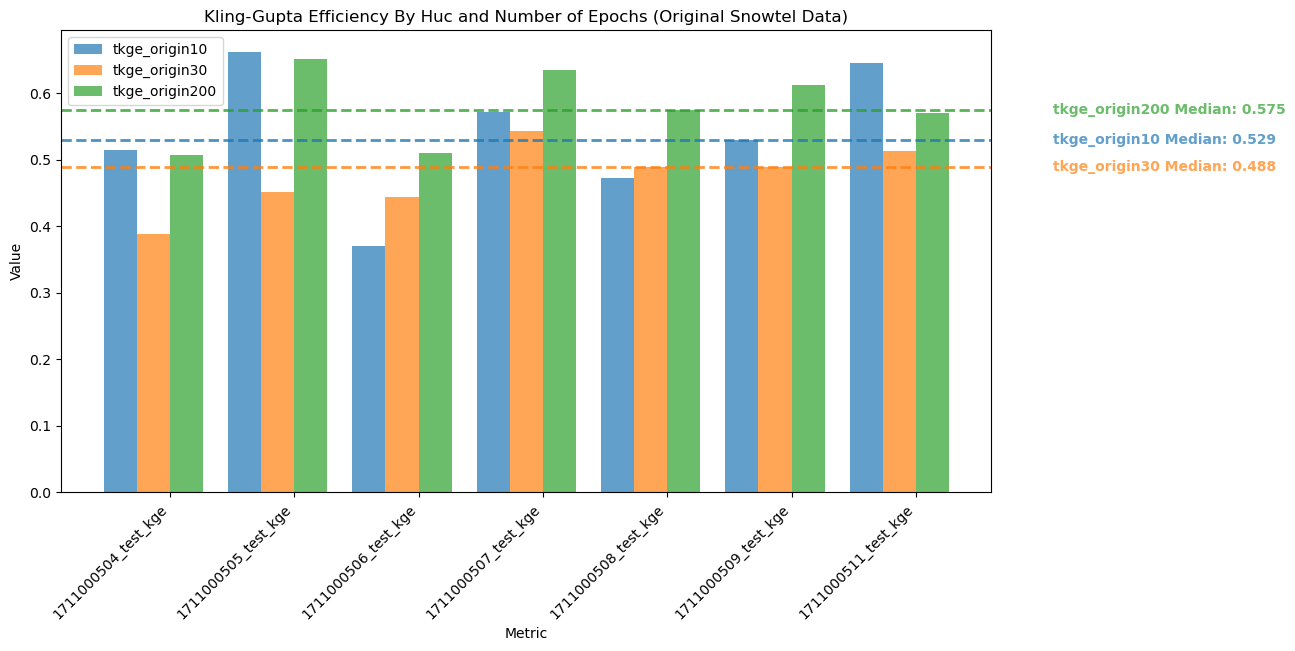

In [9]:
# Klinge-Gupta Efficency (Higher is better; 1 is Perfect) 
plot_side_by_side(df_orig10_tkge, "tkge_origin10", 
                  df_orig30_tkge, "tkge_origin30", 
                  df_orig200_tkge, "tkge_origin200",
                  title = "Kling-Gupta Efficiency By Huc and Number of Epochs (Original Snowtel Data)")


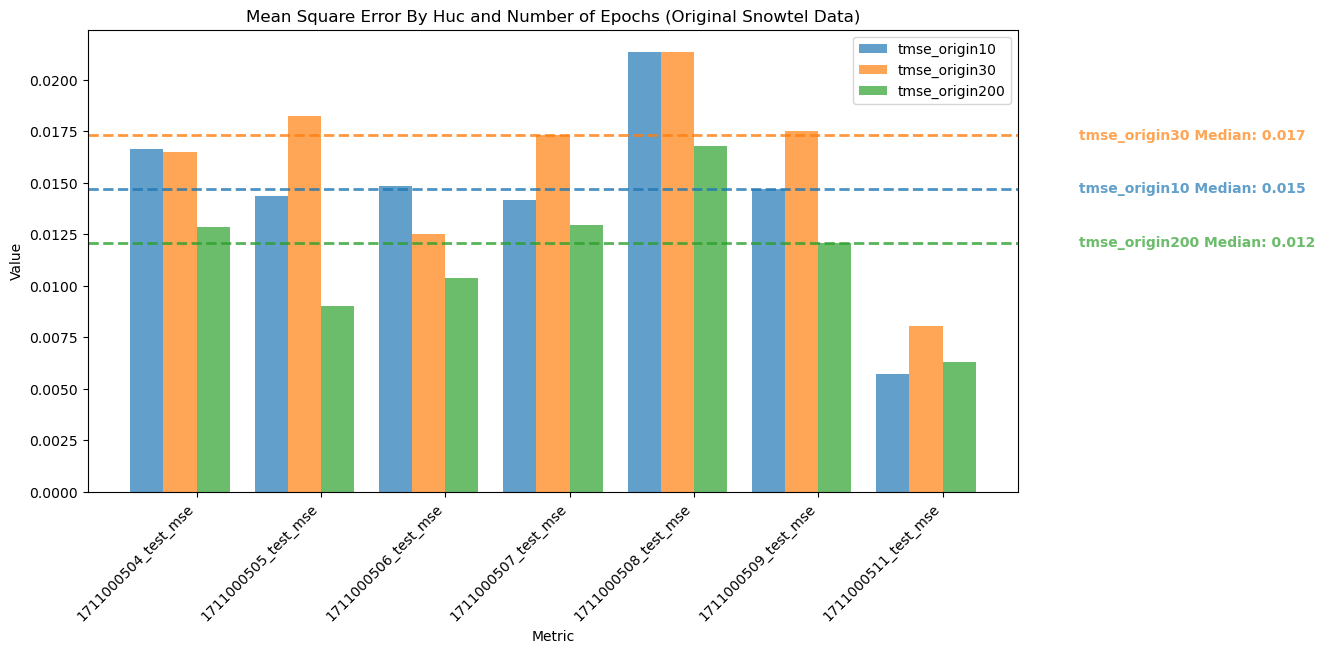

In [10]:
# MSE (Lower is better; 0 is Perfect) 
title = "Mean Square Error By Huc and Number of Epochs (Original Snowtel Data)"
plot_side_by_side(df_orig10_tmse, "tmse_origin10", df_orig30_tmse, "tmse_origin30", 
                  df_orig200_tmse, "tmse_origin200", title = title)

Using the Original Data, The Model Run Using 200 Epochs Performs the Best in Terms of Median Test KGE and Median Test MSE 

# Step 4 Compare Results for varying number of Epochs, New Data 

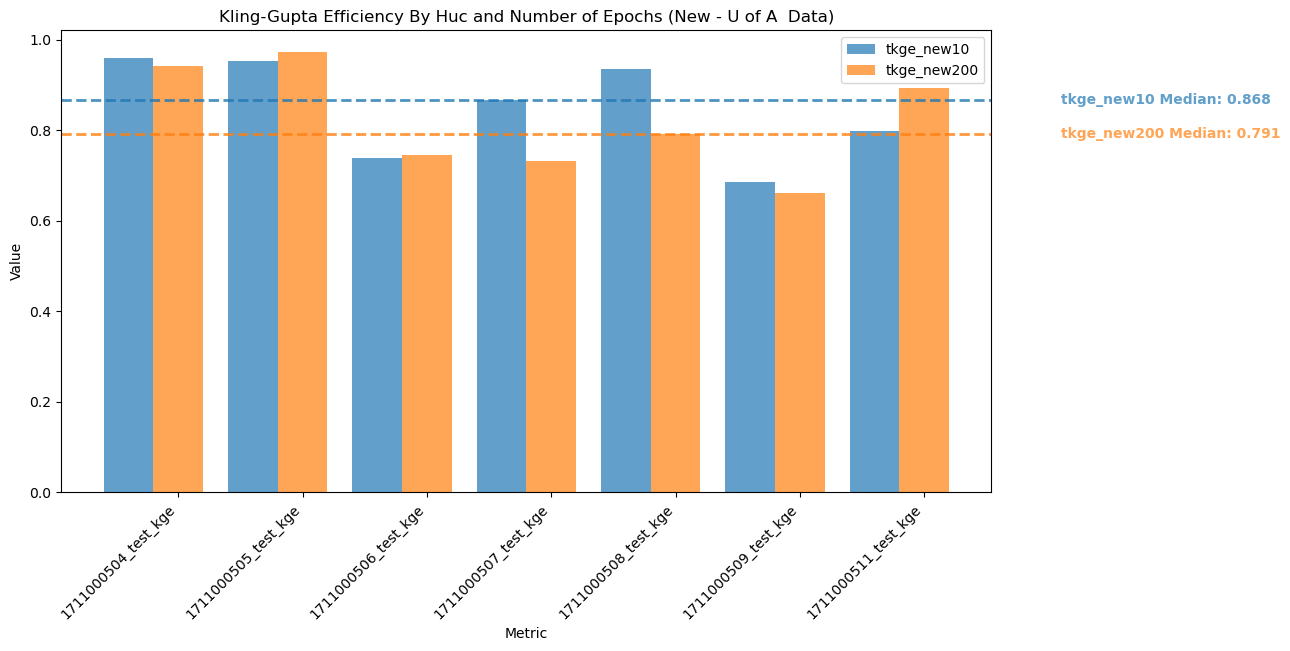

In [11]:
# Klinge-Gupta Efficency (Higher is better; 1 is Perfect) 
title = "Kling-Gupta Efficiency By Huc and Number of Epochs (New - U of A  Data)"
plot_side_by_side(df_new10_tkge, "tkge_new10", df_new200_tkge, "tkge_new200", title = title)


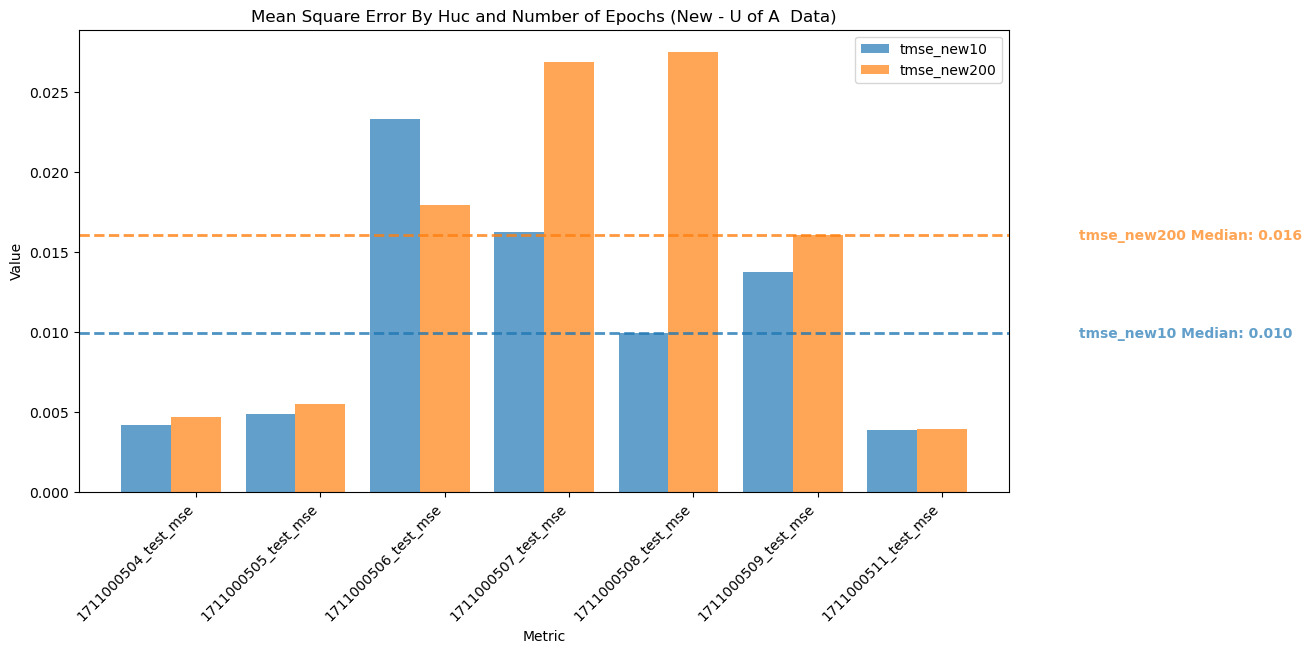

In [12]:
# MSE
title = "Mean Square Error By Huc and Number of Epochs (New - U of A  Data)"
plot_side_by_side(df_new10_tmse, "tmse_new10", df_new200_tmse, "tmse_new200", title = title)

Using the new, University of Arizona Data, the run with 10 epochs performs the best in terms of median Test KGE and median Test MSE. 
There are some discrepencies in results between individual HUCS.  

# Step 5: Compare New Data to Old Data 

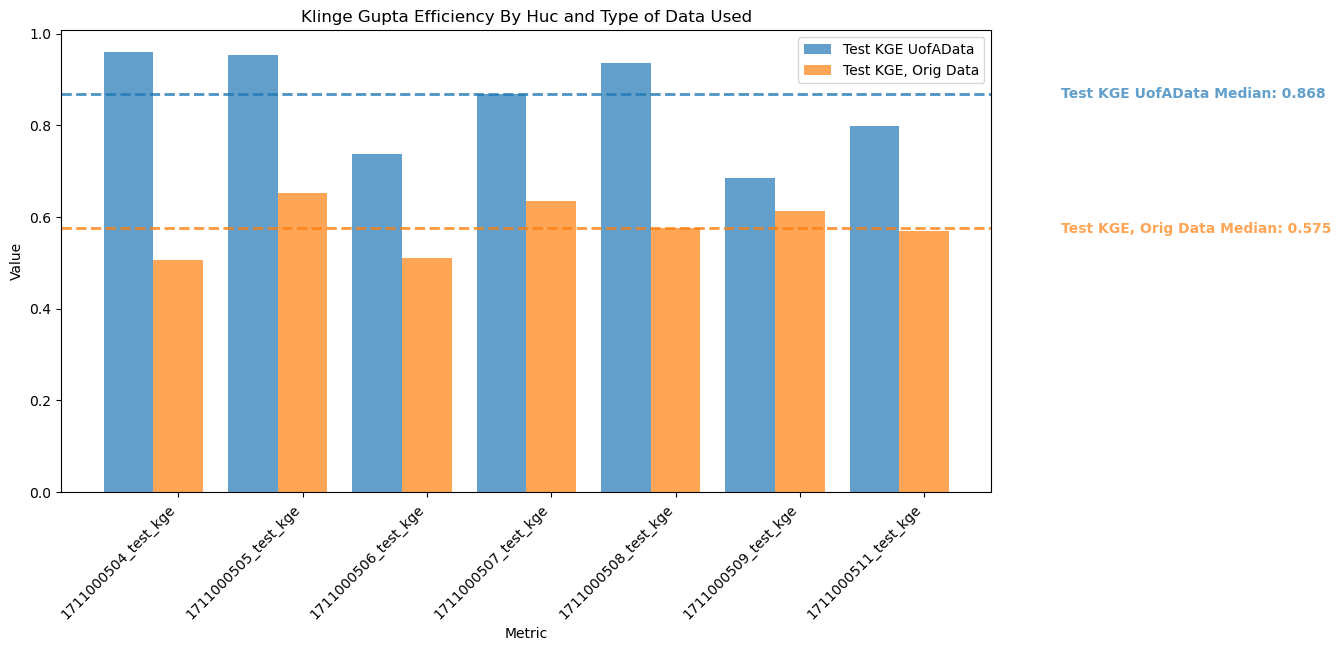

In [13]:
# Klinge-Gupta Efficency (Higher is better; 1 is Perfect) 
title = "Klinge Gupta Efficiency By Huc and Type of Data Used"
plot_side_by_side(df_new10_tkge, "Test KGE UofAData", df_orig200_tkge, "Test KGE, Orig Data", title=title, save_local=True)


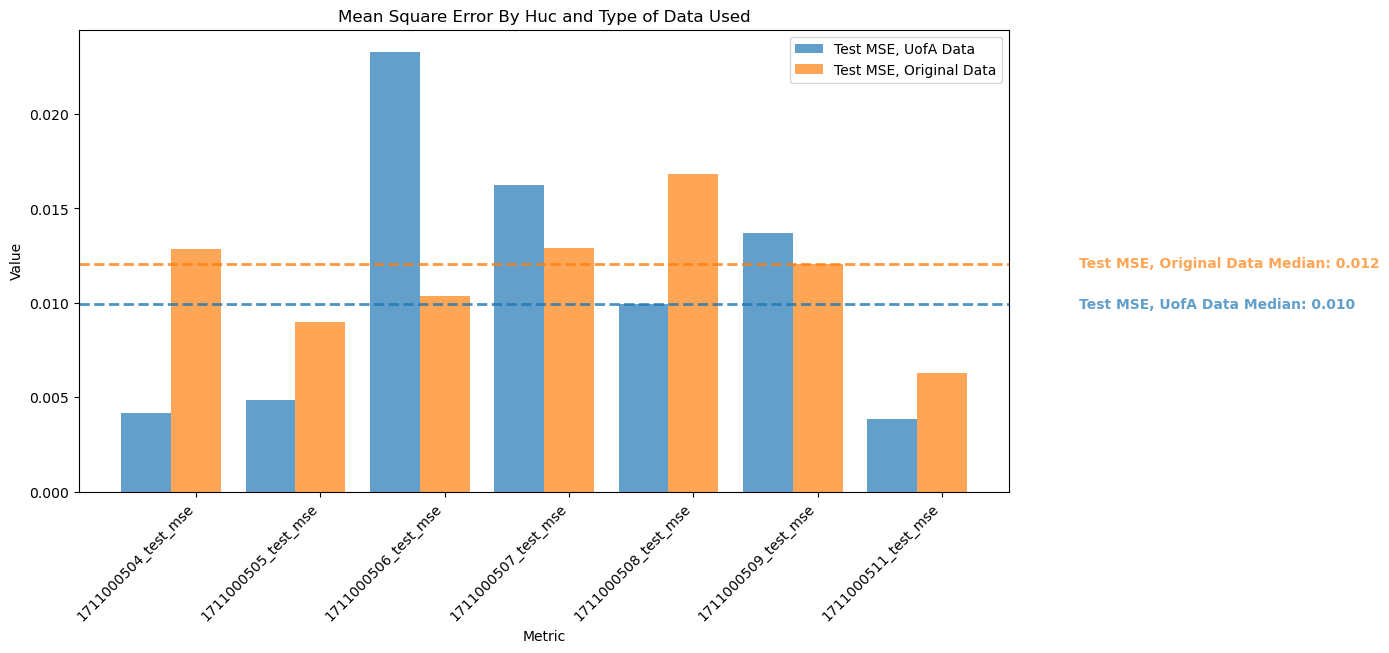

In [14]:
# MSE 
title = "Mean Square Error By Huc and Type of Data Used"
plot_side_by_side(df_new10_tmse, "Test MSE, UofA Data", df_orig200_tmse, "Test MSE, Original Data", title = title, save_local = True)


# Step 6 - Sensitivy Analysis to Epoch Selection

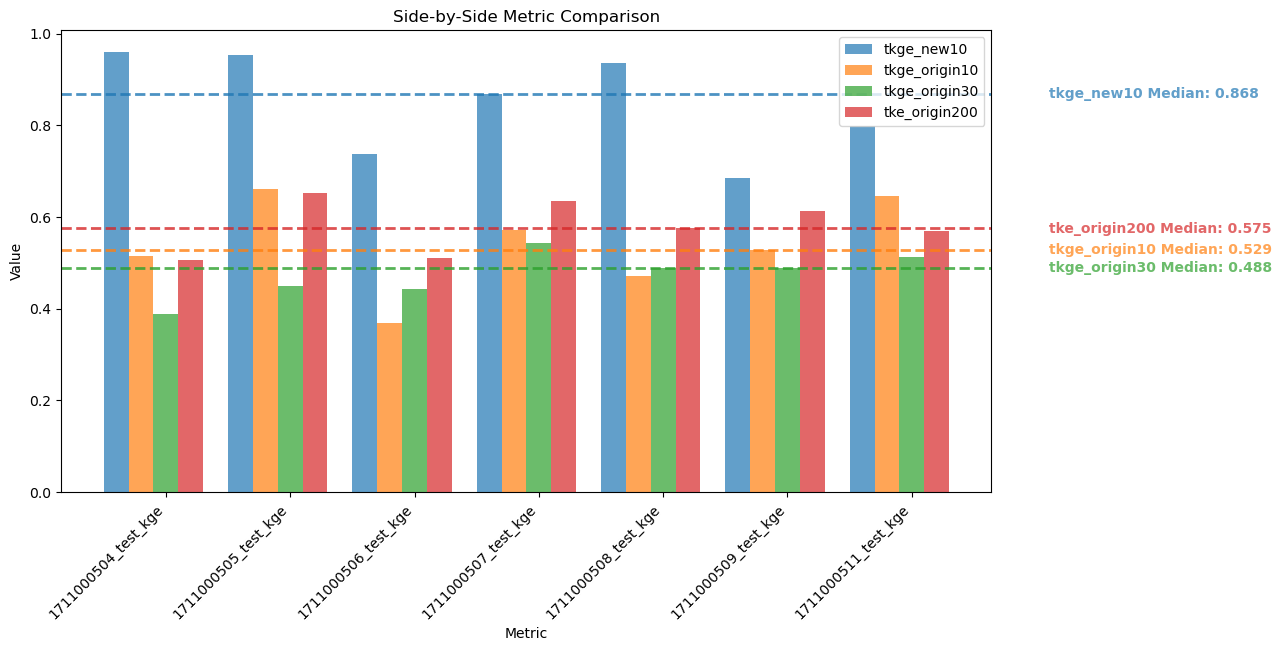

In [15]:
# Klinge-Gupta Efficency (Higher is better; 1 is Perfect) 
plot_side_by_side(df_new10_tkge, "tkge_new10", df_orig10_tkge, "tkge_origin10", df_orig30_tkge, "tkge_origin30",
                  df_orig200_tkge, "tke_origin200")

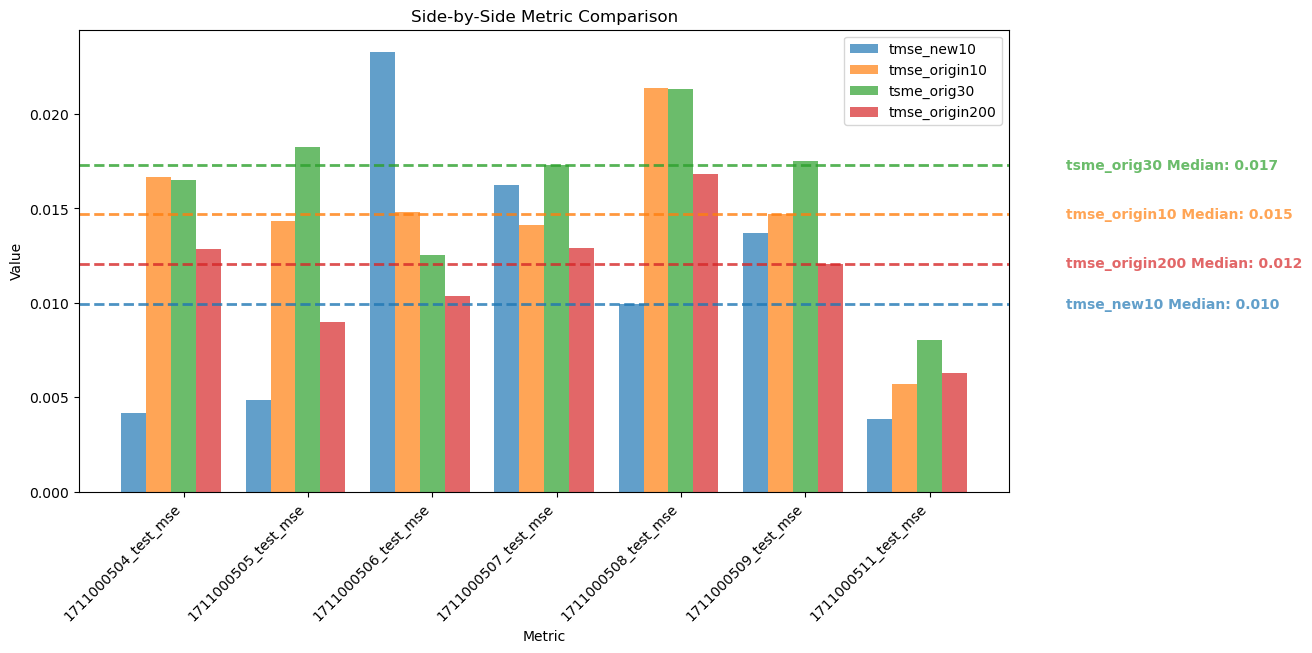

In [16]:
# MSE (Lower is better; 0 is Perfect) 
plot_side_by_side(df_new10_tmse, "tmse_new10", df_orig10_tmse, "tmse_origin10", df_orig30_tmse, "tsme_orig30", df_orig200_tmse, "tmse_origin200")

The model using the UA Data outperforms the prior model for the median Test KGE and Test MSE regardless of whether prior model runs for 10 epoxh or 200.  There is some variability among individual HUCS regarding which model performs best, however , with respect to the Test MSE metric.  

# Retrieve Specific Values 

In [17]:
newtkge_504 = df_new10_tkge[df_new10_tkge["Metric"] == "1711000504_test_kge"]["Value"]
print(f"Test KGE for huc 1711000504 using UA data was {newtkge_504}")


Test KGE for huc 1711000504 using UA data was 19    0.959328
Name: Value, dtype: float64


In [18]:
newmse_504 = df_new10_tmse[df_new10_tmse["Metric"] == "1711000504_test_mse"]["Value"]
print(f"Test MSE for huc 1711000504 using UA data was {newmse_504}")

Test MSE for huc 1711000504 using UA data was 13    0.004185
Name: Value, dtype: float64


In [19]:
oldmse_504 = df_orig200_tmse[df_orig200_tmse["Metric"] == "1711000504_test_mse"]["Value"]
print(f"Test MSE for huc 1711000504 using prior, Snowtel data was {oldmse_504}")

Test MSE for huc 1711000504 using prior, Snowtel data was 7    0.012856
Name: Value, dtype: float64


In [20]:
oldkge_504 = df_orig200_tkge[df_orig200_tkge["Metric"] == "1711000504_test_kge"]["Value"]
print(f"Test KGE for huc 1711000504 using prior, Snowtel data was {oldkge_504}")

Test KGE for huc 1711000504 using prior, Snowtel data was 27    0.507048
Name: Value, dtype: float64
